In [104]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [105]:
from langchain_chroma import Chroma

vector_store = Chroma(
    embedding_function = embeddings,
    collection_name = 'income_tax_collection2',
    persist_directory = './income_tax_collection2'
)


In [106]:
retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [ ]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

# State
class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [120]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [ ]:
# Node
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    
    return {'context': docs}

In [110]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [ ]:
from langchain import hub

generate_prompt = hub.pull("rlm/rag-prompt")

# Node
def generate(state: AgentState):
    query = state['query']
    context = state['context']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'question':query, 'context':context})
    
    return {'answer': response}

In [ ]:
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    # Literal[]을 통해 반환값이 정해진 문자열 중 하나임을 명시함.
    query = state['query']
    context = state['context']
    print(f'query: {query}')
    
    doc_relevance_chain = doc_relevance_prompt  | llm
    response = doc_relevance_chain.invoke({'question':query, 'documents':context})
    print(f'response doc relevance: {response}')
    
    if response['Score'] == 1:
        return 'generate'
    return 'rewrite'
    

In [113]:
from langchain_core.prompts import PromptTemplate

dictionary = ["사람을 나타내는 표현 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(f"""
        우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
        사전: {dictionary}
        
        질문: {{question}}     
""")

In [ ]:
from langchain_core.output_parsers import StrOutputParser

# Node
def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    
    response = rewrite_chain.invoke({'question': query})
    return {'query': response}

In [121]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [ ]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance) # 해당 노드를 실행한 후, 주어진 함수의 조건 분기에 따른 반환값으로 다음에 실행할 노드를 결정함.
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

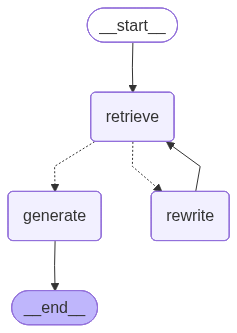

In [123]:
from IPython.display import display, Image

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [124]:
initial_state = {'query': "연봉 5천만원인 직장인의 소득세는?"}

graph.invoke(initial_state)

query: 연봉 5천만원인 직장인의 소득세는?
response doc relevance: {'Score': 0, 'Explanation': 'The provided FACTS are related to various aspects of income tax laws, such as types of income, tax exemptions, and withholding tax rates. However, the QUESTION specifically asks about the income tax for a salaried individual earning 50 million KRW annually. The FACTS do not provide any specific information or calculations related to the tax obligations or rates applicable to an individual with this specific income level, nor do they explain how the tax should be calculated for such a salary. The FACTS are general and broad in nature, focusing more on the types of income and broad tax regulations rather than specific tax calculations for a given salary. Therefore, they are not relevant to answering the QUESTION, which asks for a specific income tax calculation. Thus, the score is 0 as the FACTS do not contain any keywords or semantic meaning directly related to the calculation of income tax for a 50 million 

{'query': '거주자의 연봉이 5천만원일 때 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌───────────────┐\n│ 과세표준의 6개 구간 │\n├───────────────┤\n│ 1,400만원 이하        │ 84만원 + (1,400만원을 초과하는 금액의 15%)  │\n│ 1,400만원 초과        │ 84만원 + (5,000만원을 초과하는 금액의 24%)  │\n│ 8,800만원 이하        │ 624만원 + (5,000만원을 초